## loading data for ocean module

In [1]:
import numpy as np
from kadlu.geospatial.data_sources import hycom
from kadlu.geospatial.data_sources.fetch_util import index
from kadlu.geospatial import ocean
from kadlu.geospatial.interpolation import Interpolator3D
from importlib import reload
from datetime import datetime
from functools import reduce
reload(hycom)
self = ocean.Ocean()

/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/geospatial/data_sources/fetch_util.py:33: UserWarning: missing kadlu/config.ini. storage location will be set to /home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/storage/
  warnings.warn(f"{msg} storage location will be set to {storage_location}")
/home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/kadlu/geospatial/data_sources/fetch_util.py:33: UserWarning: missing kadlu/config.ini. storage location will be set to /home/oliskir/src/anaconda3/envs/kadlu_env/lib/python3.6/site-packages/storage/
  warnings.warn(f"{msg} storage location will be set to {storage_location}")


In [2]:
south, west = 46, -60
north, east = 48, -58
top, bottom = 0, 5000
start,  end = datetime(2015, 1, 10), datetime(2015, 1, 10, 12)

In [3]:
hycom.Hycom().fetch_temp(
        south=south, north=north, west=west, east=east,
        start=start, end=end, top=top, bottom=bottom
    )

downloading 265200 water_temp values from hycom...
downloaded 280.2Kb in 20.668s. parsed and inserted 136595 rows in 0.847s
128605 null values removed, 0 duplicate rows ignored



In [4]:
self.temp_data = hycom.Hycom().load_temp(
        south=south, north=north, west=west, east=east,
        start=start, end=end, top=top, bottom=bottom
    )

In [5]:
self.temp_data.shape

(5, 136595)

In [6]:
# build split index, reduce 4th dimension to 3D avg
splidx = np.append(
        np.nonzero(
            self.temp_data[3][1:] > self.temp_data[3][:-1]
        )[0] + 1,  
        len(self.temp_data[3])
    )
if len(splidx) > 1:  # if fourth dimension exists, take avg and reduce to 3D
    """
    assert (self.temp_data[1][splidx[0]:splidx[1]] == self.temp_data[1][splidx[1]:splidx[2]]).all()
    assert (self.temp_data[2][splidx[0]:splidx[1]] == self.temp_data[2][splidx[1]:splidx[2]]).all()
    """
    splitd = np.array([self.temp_data[0][splidx[d]:splidx[d+1]] for d in range(0, len(splidx)-1)])
    vals = (reduce(np.add, splitd) / len(splitd)).astype(float) 
    x = self.temp_data[2] [splidx[0] : splidx[1]].astype(float) 
    y = self.temp_data[1] [splidx[0] : splidx[1]].astype(float) 
    z = self.temp_data[4] [splidx[0] : splidx[1]].astype(float) 
    #warnings.warn("query data has been averaged across the time dimension for 3D interpolation"
    #        + "\nto avoid this behaviour, use keyword argument 'time' instead of start/end")
else:   # if data is already 3 dimensional, just leave as is
    vals = self.temp_data[0].astype(float)
    x = self.temp_data[2].astype(float)
    y = self.temp_data[1].astype(float)
    z = self.temp_data[4].astype(float)

xgrid = np.unique(x)
ygrid = np.unique(y)
zgrid = np.unique(z)

# reshape row data to 3D array
rowdata = np.array((vals, y, x, z)).T
gridspace = np.full((len(ygrid), len(xgrid), len(zgrid)), fill_value=-30000)
# this could probably be optimized to avoid an index lookup cost
# for every value by using a map, but i havent figured out how yet
for row in rowdata:
    x_ix = index(row[2], xgrid)
    y_ix = index(row[1], ygrid)
    z_ix = index(row[3], zgrid)
    gridspace[y_ix, x_ix, z_ix] = row[0]

self.temp_interp = Interpolator3D(
        values=gridspace,
        lats=ygrid, lons=xgrid,
        depths=zgrid, origin=self.origin,
        method='linear')


In [9]:
gridspace.shape, xgrid.shape, ygrid.shape, zgrid.shape

((51, 26, 28), (26,), (51,), (28,))

In [8]:
gridspace

array([[[-30000, -30000, -30000, ..., -30000, -30000, -30000],
        [-30000, -30000, -30000, ..., -30000, -30000, -30000],
        [-30000, -30000, -30000, ..., -30000, -30000, -30000],
        ...,
        [-17310, -17303, -17300, ..., -14951, -30000, -30000],
        [-17208, -17203, -17202, ..., -14934, -15094, -30000],
        [-17276, -17272, -17271, ..., -14836, -15092, -30000]],

       [[-30000, -30000, -30000, ..., -30000, -30000, -30000],
        [-30000, -30000, -30000, ..., -30000, -30000, -30000],
        [-30000, -30000, -30000, ..., -30000, -30000, -30000],
        ...,
        [-17350, -17343, -17340, ..., -14931, -15076, -30000],
        [-17228, -17223, -17221, ..., -14858, -15091, -30000],
        [-17301, -17297, -17296, ..., -14801, -15095, -30000]],

       [[-30000, -30000, -30000, ..., -30000, -30000, -30000],
        [-30000, -30000, -30000, ..., -30000, -30000, -30000],
        [-30000, -30000, -30000, ..., -30000, -30000, -30000],
        ...,
        [-17

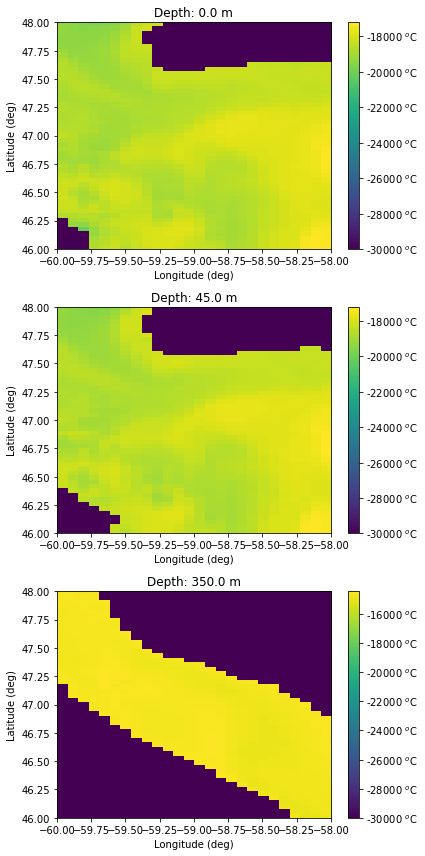

In [26]:
import matplotlib.pyplot as plt

depth_indices = [0,13,25]
fig, ax = plt.subplots(nrows=N, figsize=(6,12))

for j,i in enumerate(depth_indices):
    temp = gridspace[:,:,i]
    img = ax[j].imshow(temp, aspect='auto', origin='lower', extent=(np.min(xgrid),np.max(xgrid),np.min(ygrid),np.max(ygrid)))
    ax[j].set_xlabel('Longitude (deg)')
    ax[j].set_ylabel('Latitude (deg)')
    ax[j].set_title('Depth: {0} m'.format(zgrid[i]))
    fig.colorbar(img, ax=ax[j], format='%+2.0f $^o$C')

fig.tight_layout()    